# Train a Model using Local Computer as Compute Target

Trained models are uploaded to Azure ML into `Home > Experiments > train-on-local > {run-id} > Output + logs > outputs` and can be accessed via the API.

In [1]:
%load_ext watermark
%watermark -v -d -p sklearn,azureml.core

Python implementation: CPython
Python version       : 3.9.7
IPython version      : 7.28.0

sklearn     : 1.0.1
azureml.core: 1.35.0



In [2]:
import azureml.core

## Initialize Workspace

Create a ML workspace in **Azure ML Studio** and export `config.json`

In [4]:
from azureml.core.workspace import Workspace
import json

with open('config.json', 'r') as f:
    config = json.load(f)
    
ws = Workspace(workspace_name=config['workspace_name'], subscription_id=config['subscription_id'], resource_group=config['resource_group'])
ws.write_config()

print(ws.name, ws.resource_group, ws.location, sep='\n')

thomdml
thomd
eastus


## Create Experiment

In [5]:
from azureml.core import Experiment

exp = Experiment(workspace=ws, name='train-on-local')

Write the training script `train.py` to file

In [6]:
%%writefile train.py
from sklearn.datasets import load_diabetes
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from azureml.core.run import Run
import os
import numpy as np
import joblib

os.makedirs('./outputs', exist_ok=True)   # to save model in the outputs folder so it automatically get uploaded

X, y = load_diabetes(return_X_y=True)

run = Run.get_context()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

for alpha in np.arange(0.0, 1.0, 0.05):
    reg = Ridge(alpha=alpha)
    reg.fit(X_train, y_train)
    preds = reg.predict(X_test)
    mse = mean_squared_error(preds, y_test)
    run.log('alpha', alpha)
    run.log('mse', mse)
    model_file_name = 'ridge_{0:.2f}.pkl'.format(alpha)
    with open(model_file_name, 'wb') as file:
        joblib.dump(value=reg, filename=os.path.join('./outputs/', model_file_name))

    print('alpha is {0:.2f}, and mse is {1:0.2f}'.format(alpha, mse))


Overwriting train.py


## Run Experiment on Local Computer

In [7]:
from azureml.core import Environment
from azureml.core import ScriptRunConfig
from azureml.core.conda_dependencies import CondaDependencies

### User-Managed Environment

When using a **user-managed environment**, you are responsible for ensuring that all the necessary packages are available in the Python environment you choose to run the script in.

In [8]:
user_managed_env = Environment('user-managed-env')
user_managed_env.python.user_managed_dependencies = True

# You can choose a specific Python environment by pointing to a Python path 
#user_managed_env.python.interpreter_path = '/Users/duerr/.virtualenvs/jupyter/bin/python'

src = ScriptRunConfig(source_directory='./', script='train.py', environment=user_managed_env)
run = exp.submit(src)

Get run history details

In [9]:
# run.wait_for_completion(show_output=True)

In [10]:
run

Experiment,Id,Type,Status,Details Page,Docs Page
train-on-local,train-on-local_1636298126_8ae4a0d8,azureml.scriptrun,Running,Link to Azure Machine Learning studio,Link to Documentation


### System-Managed Environment

Instead of managing the setup of the environment yourself, you can **ask the system to build a new local conda environment** within `~/.azureml/envs/`. The environment is built once, and will be **reused** in subsequent executions as long as the conda dependencies remain unchanged.

In [11]:
system_managed_env = Environment('system-managed-env')
system_managed_env.python.user_managed_dependencies = False

# Specify conda dependencies with scikit-learn
system_managed_env.python.conda_dependencies = CondaDependencies.create(
    conda_packages=['scikit-learn', 'pip'],
    pip_packages=['azureml-core']
)
system_managed_env.environment_variables = {'PIP_REQUIRE_VIRTUALENV': 'false'}

# A new conda environment is built. If you are running this for the first time, this might take up to 5 minutes
src = ScriptRunConfig(source_directory='./', script='train.py', environment=system_managed_env)

run = exp.submit(src)

In [12]:
#run.wait_for_completion(show_output=True)
run

Experiment,Id,Type,Status,Details Page,Docs Page
train-on-local,train-on-local_1636298207_8f9059ca,azureml.scriptrun,Running,Link to Azure Machine Learning studio,Link to Documentation


### Docker-based Execution

Train the models in a **Docker container on your local machine**. For this, you then need to have the Docker engine installed **locally**.

If your kernel is already running in a Docker container, such as Azure Notebooks, this mode will **NOT** work.

In [13]:
docker_env = Environment('docker-env')

from azureml.core.runconfig import DockerConfiguration
dc = DockerConfiguration(use_docker=True)
docker_env.python.user_managed_dependencies = False

# use the default CPU-based Docker image from Azure ML
print(f'Docker Image: {docker_env.docker.base_image}')

# Specify conda dependencies with scikit-learn
docker_env.python.conda_dependencies = CondaDependencies.create(
    conda_packages=['scikit-learn', 'pip'],
    pip_packages=['azureml-core']
)
docker_env.environment_variables = {'PIP_REQUIRE_VIRTUALENV': 'false'}

src = ScriptRunConfig(source_directory='./',  script='train.py', environment=docker_env, docker_runtime_config=dc)

Docker Image: mcr.microsoft.com/azureml/openmpi3.1.2-ubuntu18.04:20210922.v1


In [14]:
import subprocess

# Check if Docker is installed and Linux containers are enabled
if subprocess.run('docker -v', shell=True).returncode == 0:
    out = subprocess.check_output('docker system info', shell=True).decode('ascii')
    if not 'OSType: linux' in out:
        print('Switch Docker engine to use Linux containers')
    else:
        run = exp.submit(src)
else:
    print('Docker engine is not installed')

Docker version 20.10.8, build 3967b7d


In [15]:
#run.wait_for_completion(show_output=True)
run

Experiment,Id,Type,Status,Details Page,Docs Page
train-on-local,train-on-local_1636298295_5b7ee13a,azureml.scriptrun,Running,Link to Azure Machine Learning studio,Link to Documentation


## Query Metrics from Azure ML

Extract the **captured metrics**:

In [16]:
run.get_metrics()
metrics = run.get_metrics()

Find the model of the last run that has the lowest MSE value logged

In [17]:
import numpy as np

best_alpha = metrics['alpha'][np.argmin(metrics['mse'])]

print('When alpha is {1:0.2f}, we have min MSE {0:0.2f}.'.format(
    min(metrics['mse']), 
    best_alpha
))

When alpha is 0.40, we have min MSE 3295.74.


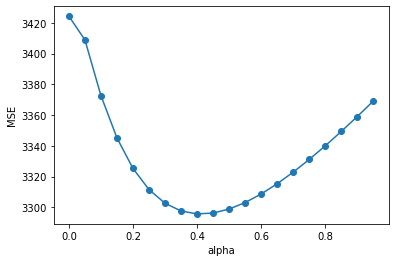

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(metrics['alpha'], metrics['mse'], marker='o')
plt.ylabel("MSE")
plt.xlabel("alpha");

List all the files that are associated with this run record:

In [19]:
run.get_file_names()

['azureml-logs/60_control_log.txt',
 'azureml-logs/70_driver_log.txt',
 'logs/azureml/8_azureml.log',
 'outputs/ridge_0.00.pkl',
 'outputs/ridge_0.05.pkl',
 'outputs/ridge_0.10.pkl',
 'outputs/ridge_0.15.pkl',
 'outputs/ridge_0.20.pkl',
 'outputs/ridge_0.25.pkl',
 'outputs/ridge_0.30.pkl',
 'outputs/ridge_0.35.pkl',
 'outputs/ridge_0.40.pkl',
 'outputs/ridge_0.45.pkl',
 'outputs/ridge_0.50.pkl',
 'outputs/ridge_0.55.pkl',
 'outputs/ridge_0.60.pkl',
 'outputs/ridge_0.65.pkl',
 'outputs/ridge_0.70.pkl',
 'outputs/ridge_0.75.pkl',
 'outputs/ridge_0.80.pkl',
 'outputs/ridge_0.85.pkl',
 'outputs/ridge_0.90.pkl',
 'outputs/ridge_0.95.pkl']

The model `ridge_0.40.pkl` is the best performing model. 

Now register that model with the workspace. Then find that model in the portal within **Models**.

In [20]:
model = run.register_model(model_name='best_ridge_model', model_path='./outputs/ridge_0.40.pkl')

print("Registered model:\n\n--> Name: {}\n--> Version: {}\n--> URL: {}".format(model.name, model.version, model.url))

Registered model:

--> Name: best_ridge_model
--> Version: 1
--> URL: aml://asset/ee1ca5983af84ced86bc6e4291a8b13a


Now **download** model to local computer:

In [21]:
import os
os.makedirs('./model', exist_ok=True)

run.download_file(name='./outputs/ridge_0.40.pkl', output_file_path='./model/model.pkl')